In [1]:
pip install -U classiq

     ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
     -------- ------------------------------- 0.5/2.4 MB 5.7 MB/s eta 0:00:01
     ---------------------------------------  2.4/2.4 MB 7.1 MB/s eta 0:00:01
     ---------------------------------------- 2.4/2.4 MB 7.1 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 5.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------- 2.0/2.0 MB 11.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   -


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import classiq
classiq.authenticate() # Uncoment to authenticate. For the first (local) run only

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\classiq\_internals\authentication\token_manager.py:101: UserWarning: Device is already registered.
Generating a new refresh token should only be done if the current refresh token is compromised.
To do so, set the overwrite parameter to true
  warnings.warn(


In [2]:
# All the imports needed:
from classiq import *
from classiq.execution import *
from classiq.qmod.symbolic import *
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [14]:
# ## TODO: Write Your Functions Here ## (Final)

# def create_solution(resolution: int): # Don't change!
#     fraction_digits = resolution - 2  # Don't change!
#     EXP_RATE = 1                      # Don't change!



#     ## TODO: Write Your Functions Here: ##

#     def gaussian(x, lambd=EXP_RATE):
#         return np.exp(-lambd * x ** 2)

#     LEFTMOST_POINT=-2
#     RIGHTMOST_POINT=2 # this point won't be included as x ranges in [-2,2)

    

#     x = np.linspace(LEFTMOST_POINT,RIGHTMOST_POINT, resolution, endpoint=False)
#     unnormalized_G = gaussian(x)
#     normalized_G = unnormalized_G / np.sum(unnormalized_G) ##normalized probablity distribution
    

#     # @qfunc
#     # def prepare_gaussian(x: QNum):
#     #     # Prepare the Gaussian state using the normalized probabilities
        
#     #     prepare_state(probabilities=normalized_G.tolist(), bound=0.01, out=x)

#     # return prepare_gaussian


#     @qfunc
#     def prepare_gaussian(x: QNum):
#         # Prepare the Gaussian state using the normalized probabilities
#         prepare_state(probabilities=normalized_G.tolist(), bound=0.01, out=x)

#     return prepare_gaussian

In [143]:

def create_solution(resolution: int):  # Don't change!
    fraction_digits = resolution - 2  # Don't change!
    EXP_RATE = 1  # Don't change!


    num_states =2**(resolution-1)
    x_values = np.linspace(-2, 2, num_states, endpoint=False)

    gaussian_probs = np.exp(-EXP_RATE * x_values**2)
    gaussian_probs /= np.sum(gaussian_probs)  # Normalize
    phase_angles = np.angle(np.sqrt(gaussian_probs))  # Extract phase shifts


    @qfunc
    def phase_shift(x: QNum):
        for i, angle in enumerate(phase_angles):
         if angle != 0:  # Apply phase shifts only if the angle is not zero
          PHASE(angle, x[i])  # Apply phase rotation to each qubit in QNum


    # Step 4: Quantum Function to Prepare Gaussian State
    @qfunc
    def prepare_gaussian(x: QNum):
        hadamard_transform(x)  # Equal Superposition
        qft(x)  # Apply QFT
        phase_shift(x)  # Apply Gaussian Phase Encoding
        invert(stmt_block=lambda: qft(x))   # Convert back to Computational Basis
       

    return prepare_gaussian

    # this is base solution,i wont touch it
    




ModuleNotFoundError: No module named 'classiq.builtin_functions'

In [139]:

def create_solution(resolution: int):  # Don't change!
    fraction_digits = resolution - 2  # Don't change!
    EXP_RATE = 1  # Don't change!

    # Step 1: Define the Discrete Domain
    num_states = 2**(resolution)
    x_values = np.linspace(-2, 2, num_states, endpoint=False)

    # Step 2: Compute Gaussian Phase Function with Higher Precision
    gaussian_probs = np.exp(-EXP_RATE * x_values**2)
    gaussian_probs /= np.sum(gaussian_probs)  # Normalize

    # Instead of using np.angle, compute optimized phase shifts directly
    phase_angles = -np.log(gaussian_probs + 1e-10)  # Avoid log(0) error
    phase_angles = (phase_angles - np.min(phase_angles))  # Normalize phase shifts
    phase_angles /= np.max(phase_angles)  # Scale between 0 and 1
    phase_angles *= np.pi  # Scale to [0, π] for better encoding

    # Define phase_shift function with higher-precision encoding
    # @qfunc
    # def phase_shift(x: QNum):
    #     for i, angle in enumerate(phase_angles):
    #         if angle > 1e-6:  # Apply phase shifts only if significant
    #             PHASE(angle, x[i])  # Apply optimized phase encoding
    @qfunc
    def phase_shift(x: QNum):
        for i, angle in enumerate(phase_angles):
         if angle != 0:  # Apply phase shifts only if the angle is not zero
          PHASE(angle,x)  # Apply phase rotation to each qubit in QNum




    # Step 4: Quantum Function to Prepare Gaussian State
    @qfunc
    def prepare_gaussian(x: QNum):
        hadamard_transform(x)  # Step 1: Equal Superposition
        qft(x)  # Step 2: Apply QFT
        phase_shift(x)# Step 3: Apply Optimized Gaussian Phase Encoding
        invert(lambda: qft(x))  # Step 4: Convert back to Computational Basis

    return prepare_gaussian


In [141]:
# This function is used to generate the quantum model from the main function for stages 1 & 2 and synthesize it with all the appropriate parameters

def create_qprog(prepare_gaussian_function, resolution: int, num_shots: int=1, optimization_parameter: str="CX", stage=int):
    fraction_digits = resolution - 2
    
    @qfunc
    def main(x: Output[QNum[resolution, SIGNED, fraction_digits]]):
        # Allocate the quantum variable x with the specified resolution
        allocate(x.size, x)

        # Prepare Gaussian state
        prepare_gaussian_function(x)


    # Backend preferences for the state vector simulator
    backend_preferences = ClassiqBackendPreferences(
        backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
    )

    # Generate the quantum model with constraints by stage
    if stage==1:
        qmod = create_model(
            main,
            execution_preferences=ExecutionPreferences(
                num_shots=num_shots, backend_preferences=backend_preferences
            ),
            constraints=Constraints(
                max_width=18, optimization_parameter=optimization_parameter
            ),
        )
    elif stage==2:
        qmod = create_model(
            main,
            preferences = Preferences(timeout_seconds=1000),
            execution_preferences=ExecutionPreferences(
                num_shots=num_shots, backend_preferences=backend_preferences
            ),
            constraints=Constraints(
                max_width=127, optimization_parameter=optimization_parameter
            ),
        )
    else:
        return "The `stage` variable should be set as Int to be either 1 or 2"
        

    # Synthesize the quantum program
    qprog = synthesize(qmod)

    return qprog

In [142]:
resolution_stage_1 = 8 # Don't change!
qprog_stage_1 = create_qprog(create_solution(resolution_stage_1), resolution_stage_1, stage=1)

NameError: name 'qiter' is not defined

In [124]:
show(qprog_stage_1)

Opening: https://platform.classiq.io/circuit/2sTgbHn23gRCRGqHLCgjx5EHRBb?version=0.66.1


In [125]:
result_stage_1 = execute(qprog_stage_1).get_sample_result()

In [126]:
result_stage_1.parsed_state_vector

[SimulatedState(state={'x': 0.546875}, bitstring='00100011', amplitude=(0.06250000000000007-3.412149224572551e-16j)),
 SimulatedState(state={'x': 0.078125}, bitstring='00000101', amplitude=(0.06250000000000006-2.0669238517468857e-16j)),
 SimulatedState(state={'x': -1.453125}, bitstring='10100011', amplitude=(0.06250000000000006-3.4570052821689646e-16j)),
 SimulatedState(state={'x': 0.046875}, bitstring='00000011', amplitude=(0.06250000000000004-2.9209355037645865e-16j)),
 SimulatedState(state={'x': 0.09375}, bitstring='00000110', amplitude=(0.06250000000000004-2.41349523740824e-16j)),
 SimulatedState(state={'x': 0.203125}, bitstring='00001101', amplitude=(0.06250000000000004-3.201914948099282e-16j)),
 SimulatedState(state={'x': 0.265625}, bitstring='00010001', amplitude=(0.06250000000000004-2.2699813399648613e-16j)),
 SimulatedState(state={'x': 0.5625}, bitstring='00100100', amplitude=(0.06250000000000004-1.0572612720347204e-16j)),
 SimulatedState(state={'x': 0.578125}, bitstring='0010

In [118]:
def scatter_aggregated_amplitudes_with_theory(parsed_state_vector, resolution: int, should_plot: bool=True):
    """
    Aggregate squared amplitudes by x, sum them, and scatter plot with theoretical distribution.
    Also calculates Mean Squared Error (MSE).

    Parameters:
        res: Parsed state vector results (list of SimulatedState objects).
        exp_rate: Exponential rate for the Gaussian distribution.
        resolution: Number of qubits used in the Gaussian state.
        should_plot: bool that allow you to choose if to plot the solution
    """
    from collections import defaultdict
    fraction_digits = resolution - 2
    EXP_RATE = 1
    
    # Initialize a dictionary to store sums of squared amplitudes
    amplitude_sums = defaultdict(int)
    for state in parsed_state_vector:
        amplitude_sums[state.state['x']] += np.abs(state.amplitude)**2

    # Prepare data for plotting
    x_values = sorted(amplitude_sums)  # Sort for meaningful plotting
    summed_squared_norms = [amplitude_sums[x] for x in x_values]

    # Generate theoretical Gaussian distribution
    grid = np.linspace(-2**(resolution-fraction_digits-1), 2**(resolution-fraction_digits-1)-2**(-fraction_digits), 2**(resolution))

    theoretical_gaussian = np.exp(-EXP_RATE * grid**2)
    theoretical_gaussian /= np.sum(theoretical_gaussian)  # Normalize the Gaussian

    # Interpolate theoretical probabilities at measured points
    interp_func = np.interp(x_values, grid, theoretical_gaussian)
    interpolated_theoretical_prob = interp_func

    # Calculate Mean Squared Error (MSE)
    mse = np.mean((np.array(summed_squared_norms) - interpolated_theoretical_prob)**2)
    print("Mean Squared Error (MSE):", mse)

    # Plot measured and theoretical distributions
    if should_plot:
        plt.figure(figsize=(8, 6))
        plt.scatter(x_values, summed_squared_norms, color='blue', alpha=0.7, label='Measured (Summed Squared Norms)')
        plt.plot(grid, theoretical_gaussian, color='red', linewidth=2, label='Theoretical Gaussian')
        plt.xlabel('x')
        plt.ylabel('Probability')
        plt.title('Measured vs Theoretical Gaussian')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return mse

Mean Squared Error (MSE): 9.318648858251803e-06


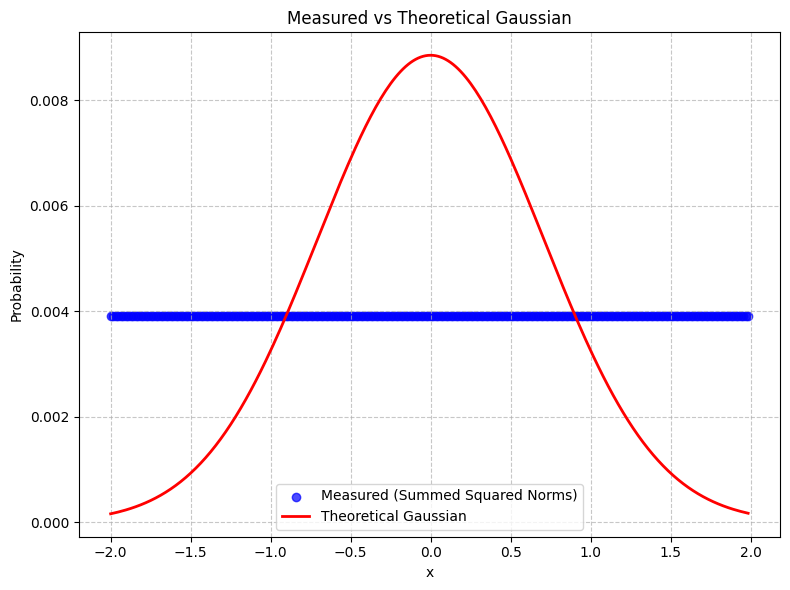

NameError: name 'get_metrics' is not defined

In [127]:
mse = scatter_aggregated_amplitudes_with_theory(result_stage_1.parsed_state_vector, resolution_stage_1, should_plot=True) 
print(get_metrics(qprog_stage_1))